# Classifying Track Events

This notebook explores how well we can classify correct/incorrect track events using some basic features of tracks. Currently you can explore divisions or migrations.

## The Data

The `all_node_info.csv` csv contains information for all datasets about each node, what component it's part of, whether it's taking part in a division or not, whether the division/migration is correct, and the relevant features of each event we've computed so far.

In [2]:
import pandas as pd

csv_path = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint/all_node_info.csv'
all_info_df = pd.read_csv(csv_path)
all_info_df.head()

,ds_name,node_id,node_area,component_id,comp_merge,comp_div,comp_correct,is_parent,is_superparent,is_merge_vertex,...,second_chosen_neighbour_rank,first_child_distance,first_child_area,second_child_distance,second_child_area,div_cost,mig_correct,child_area_prop,neighbour_rank_difference,neighbour_rank_sum
0,Fluo-C3DL-MDA231_01,0,3097.0,0,False,False,True,False,False,False,...,-1,11.247745,3052.0,-1.0,-1.0,-1.0,True,-1.0,-1,-1
1,Fluo-C3DL-MDA231_01,324,3055.0,0,False,False,True,False,False,False,...,-1,-1.000000,-1.0,-1.0,-1.0,-1.0,False,-1.0,-1,-1
2,Fluo-C3DL-MDA231_01,296,3394.0,0,False,False,True,False,False,False,...,-1,7.046125,3055.0,-1.0,-1.0,-1.0,True,-1.0,-1,-1
3,Fluo-C3DL-MDA231_01,267,3226.0,0,False,False,True,False,False,False,...,-1,2.762491,3394.0,-1.0,-1.0,-1.0,True,-1.0,-1,-1
4,Fluo-C3DL-MDA231_01,238,3462.0,0,False,False,True,False,False,False,...,-1,13.669790,3226.0,-1.0,-1.0,-1.0,True,-1.0,-1,-1


### Column Reference

- `ds_name`: name of the dataset and sequence
- `node_id`: id of this record's node
- `node_area`: pixel area of the node from regionprops,
- `component_id`: integer ID of the connected component this node belongs to in the solution
- `comp_merge`: true if component this node belongs to contains a merge
- `comp_div`: true if component this node belongs to contains a div
- `comp_correct`: true if component this node belongs to is entirely correct
- `is_parent`: true if node is a parent of a division
- `is_superparent`: true if node is a parent of 3+ children
- `is_merge_vertex`: true if the node has two incoming edges
- `child_distance_difference`: 1 if node is not a parent, otherwise difference in distance to (two closest) children
- `child_distance_sum`: -1 if node is not a parent, otherwise sum of distances to two closest children
- `interchild_distance`: -1 if node is not a parent, otherwise distance between two closest children
- `div_angle`: -1 if node is not a parent, otherwise angle in degrees between two closest children (arcos of dot product of vectors from parent to children scaled by product of magnitudes)
- `child_area_sum`: sum of areas of two children if node is parent, otherwise -1
- `div_correct`: True if node is parent and both children are correct, otherwise False
- `div_valid`: True if node is parent and there is division flow into node
- `first_chosen_neighbour_rank`: -1 if node has no successors, otherwise distance rank of the first child
- `second_chosen_neighbour_rank`: -1 if node is not a parent, otherwise distance rank of the second child
- `first_child_distance`: -1 if node has no successors, otherwise distance to the closest child
- `first_child_area`: -1 if node has no successors, otherwise area of the first child
- `second_child_distance`: -1 if node is not a parent, otherwise distance to the second closest child
- `second_child_area`: -1 if node is not a parent, otherwise area of the second child,
- `div_cost`: cost of the Dv edge for node v (regardless of whether it was used)
- `mig_correct`: True if node is not a parent, and the edge to its child is correct, otherwise False
- `child_area_prop`: -1 if node is not a parent, otherwise sum of areas of two closest children as proportion of parent area
- `neighbour_rank_difference`: -1 if node is not a parent, otherwise difference in ranks of two closest neighbours
- `neighbour_rank_sum`: -1 if node is not a parent, otherwise sum in ranks of two closest neighbours

## Divisions

Let's first look only at parents of divisions.

In [3]:
all_divisions = all_info_df[all_info_df.is_parent]


### Supervised Classifier

We train a RandomForest classifier to predict whether a divisoin is correct or not based on some features of interest. We use a randomized search for the hyperparameters (`n_estimators` and `max_depth`) and take the best estimator to use on the test set (20% of the data). We only classify datasets with >15 divisions present. We keep the `search` objects so we can investigate whether our hyperparameter search converged, was sensitive to parameter choices, etc.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

ds_names = all_divisions.ds_name.unique()
columns_of_interest = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'div_valid',
    'neighbour_rank_sum',
    'neighbour_rank_difference',
    'child_area_prop',
    'div_correct'       # this will be our target
]

record_ds_name = []
accuracies = []
n_mig = []
n_train_true = []
n_test = []
best_models = {}
searches = {}
for ds_name in ds_names:
    data_df = all_divisions[all_divisions.ds_name == ds_name][columns_of_interest]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['div_correct'])
    y = data_df.div_correct
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestClassifier()
    param_dist = {
        # number of trees
        'n_estimators': randint(2,100),
        # depth of the tree
        'max_depth': randint(2,30)
    }

    # searching for best hyperparameters using randomized search
    search = RandomizedSearchCV(
        rf,
        param_distributions = param_dist,
        n_iter = 10,
        cv = 5
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_models[ds_name] = best_model
    searches[ds_name] = search
    
    record_ds_name.append(ds_name)
    accuracies.append(accuracy)
    n_mig.append(len(data_df))
    n_train_true.append(len(X_train))
    n_test.append(len(X_test))
classifier_df = pd.DataFrame({
    'ds_name': record_ds_name,
    'accuracy': accuracies,
    'n_div': n_mig,
    'n_train': n_train_true,
    'n_test': n_test
})
print(classifier_df)

             ds_name  accuracy  n_div  n_train  n_test
0  Fluo-N2DL-HeLa_01  0.842105     93       74      19
1  Fluo-N2DL-HeLa_02  0.840909    220      176      44
2    BF-C2DL-MuSC_01  1.000000     56       44      12
3    BF-C2DL-MuSC_02  0.928571     69       55      14
4     BF-C2DL-HSC_02  0.750000    160      128      32
5    PhC-C2DL-PSC_01  0.911243    843      674     169
6    PhC-C2DL-PSC_02  0.913978    463      370      93
7    Fluo-N3DH-CE_01  0.897059    336      268      68
8    Fluo-N3DH-CE_02  0.916667    239      191      48


Checking our hyperparameter search accuracy, we see that it's pretty scattered across the different options that we tried.

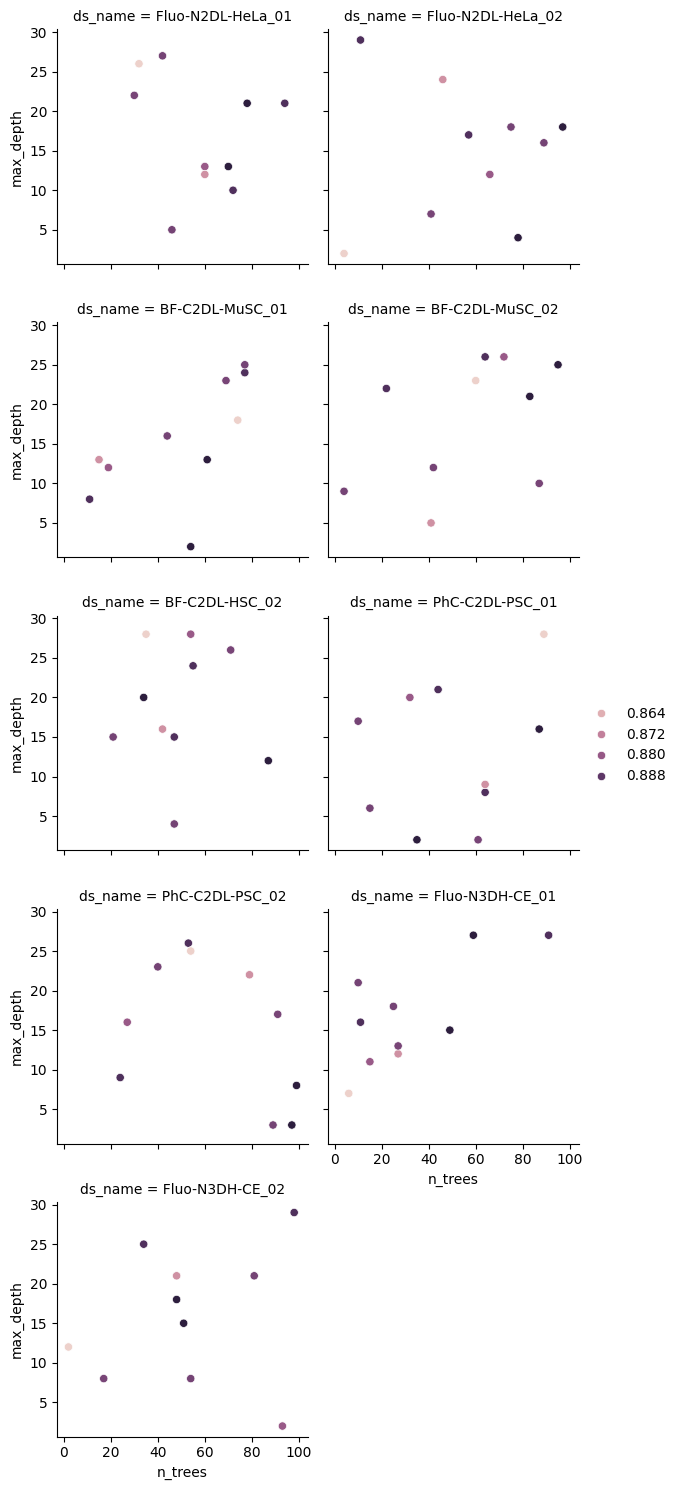

In [5]:
import seaborn as sns
ds_names = []
n_estimators = []
max_depths = []
scores = []
for ds_name, search in searches.items():
    search_results = search.cv_results_
    m_depth = search_results['param_max_depth']
    n_est = search_results['param_n_estimators']
    score = search_results['mean_test_score']

    ds_names.extend([ds_name for _ in range(len(m_depth))])
    n_estimators.extend(n_est)
    max_depths.extend(m_depth)
    scores.extend(score)
search_df = pd.DataFrame({
    'ds_name': ds_names,
    'n_trees': n_estimators,
    'max_depth': max_depths,
    'score': scores
})
grid = sns.FacetGrid(search_df, col='ds_name', col_wrap=2, sharex=True, sharey=True, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='n_trees', y='max_depth', hue=score)
grid.add_legend()

We now check our best estimator against different test/train splits to see whether our performance is comparable and our standard deviation is low.

In [6]:
from sklearn.model_selection import cross_val_score

ds_names = []
average_score = []
std_dev = []
for ds_name, model in best_models.items():
    data_df = all_divisions[all_divisions.ds_name == ds_name][columns_of_interest]
    X = data_df.drop(columns=['div_correct'])
    y = data_df.div_correct
    scores = cross_val_score(model, X, y, cv=5)
    ds_names.append(ds_name)
    average_score.append(scores.mean())
    std_dev.append(scores.std())
cross_val_df = pd.DataFrame({
    'ds_name': ds_names,
    'average_score': average_score,
    'std_dev': std_dev
})
cross_val_df

,ds_name,average_score,std_dev
0,Fluo-N2DL-HeLa_01,0.890643,0.093340
1,Fluo-N2DL-HeLa_02,0.859091,0.056408
2,BF-C2DL-MuSC_01,0.946970,0.043387
3,BF-C2DL-MuSC_02,0.985714,0.028571
4,BF-C2DL-HSC_02,0.900000,0.023385
5,PhC-C2DL-PSC_01,0.883805,0.040974
6,PhC-C2DL-PSC_02,0.928728,0.029531
7,Fluo-N3DH-CE_01,0.913565,0.024111
8,Fluo-N3DH-CE_02,0.865957,0.022376


### K-Means Unsupervised Classifier

We now see whether an unsupervised method can help us find the correct/incorrect classes without us knowing any labels at all. This includes the `div_valid` column which is binary. This data is unscaled.

In [7]:
from sklearn.cluster import k_means

ds_names = all_divisions.ds_name.unique()

kmeans_cols = columns_of_interest
kmeans_clustered = {}
for ds_name in ds_names:
    data_df = all_divisions[all_divisions.ds_name == ds_name][kmeans_cols]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['div_correct'])

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    kmeans_clustered[ds_name] = data_df

We look at the contingency table between cluster assignment and division correctness. As we can see, there's a lot of confusion. A perfect classifier here would have one very bright and one very dark diagonal.

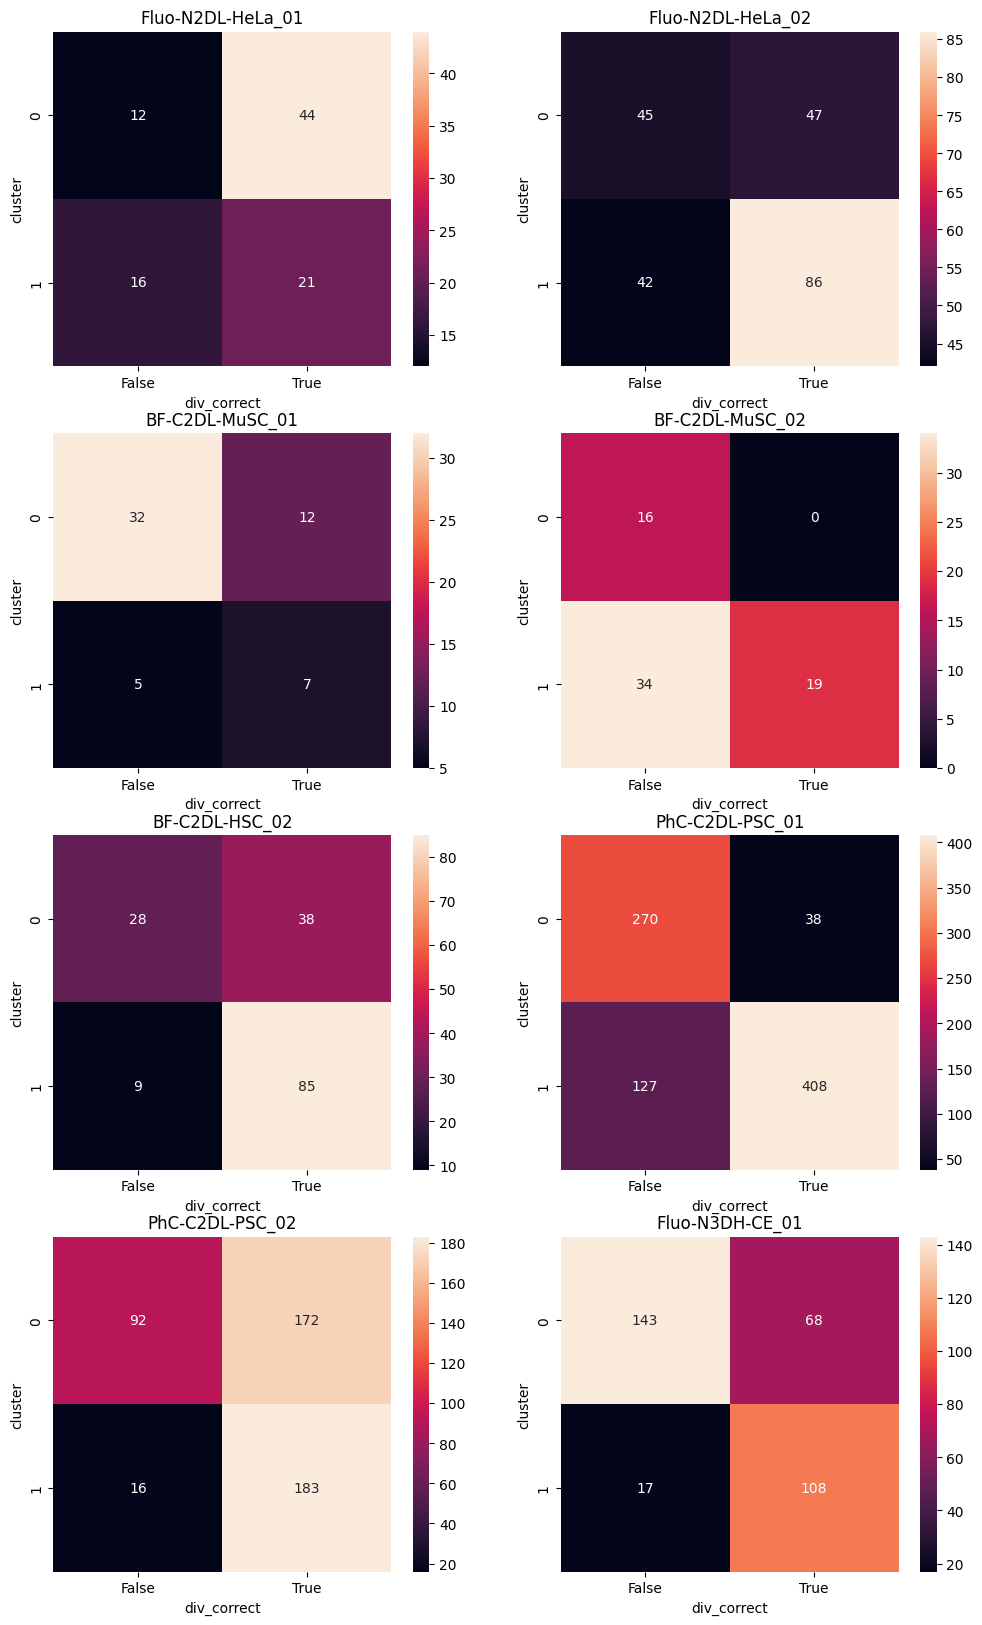

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(kmeans_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = kmeans_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax);
    ax.set_title(key)
plt.show()

We now check whether scaling the data helps with the classification ability, since the values are in very different units. We remove any features that are binary or take on very few values for this.

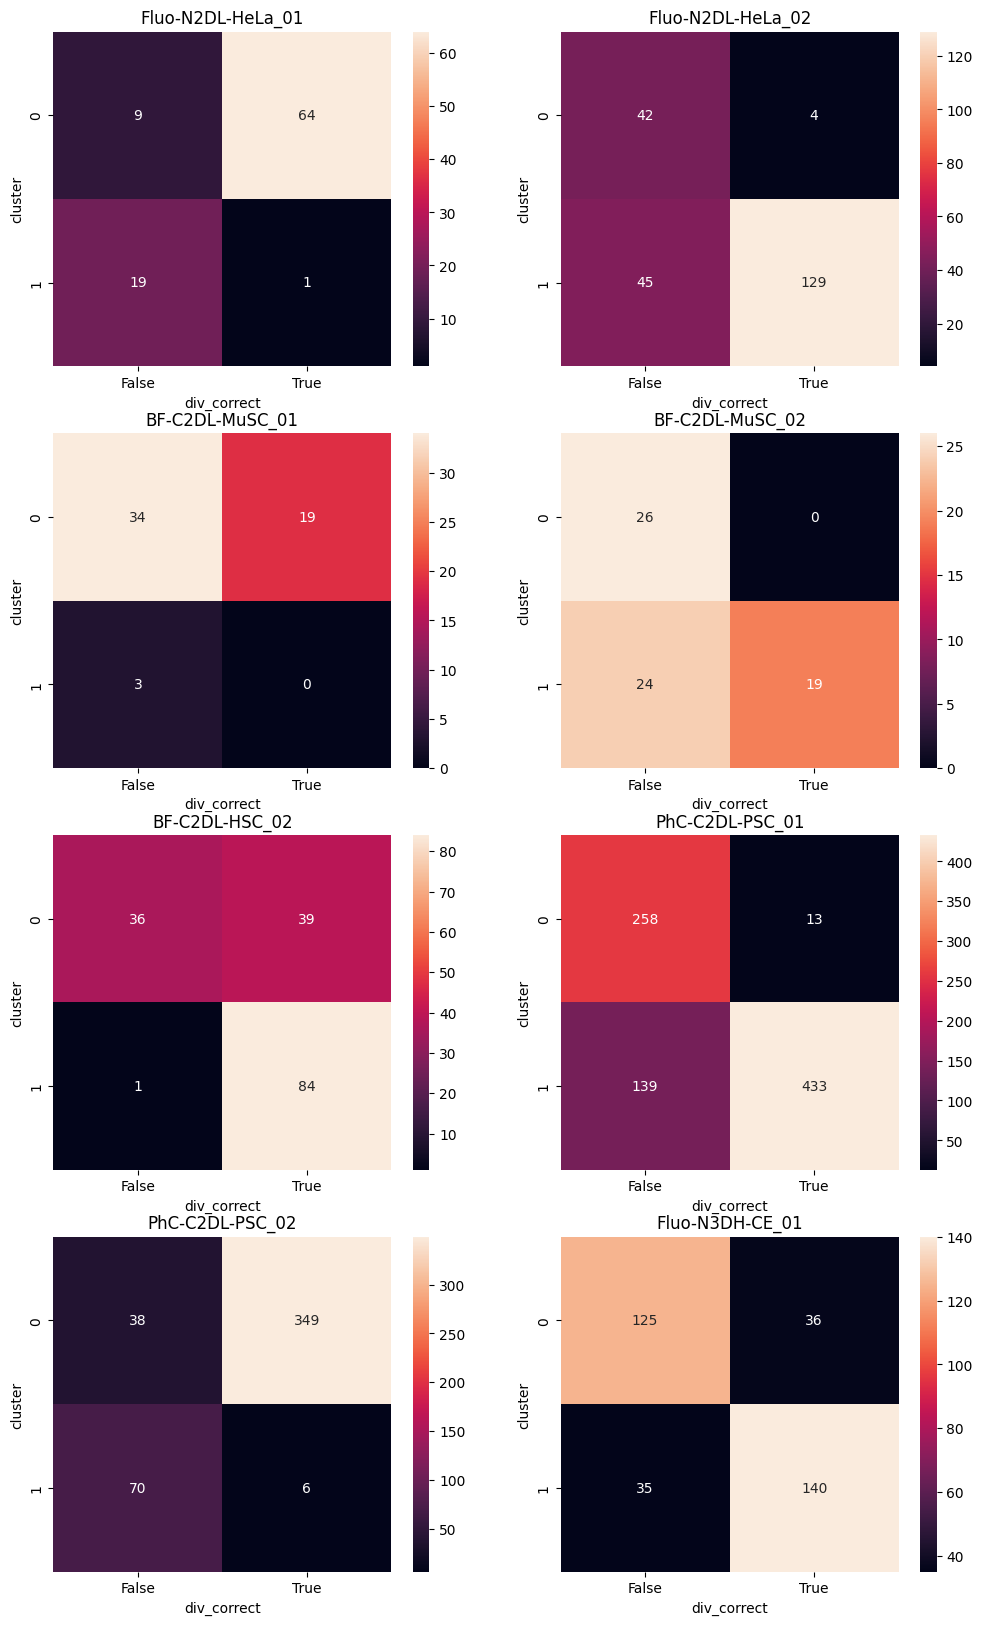

In [9]:
from sklearn.cluster import k_means
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ds_names = all_divisions.ds_name.unique()

# no longer using div_valid, neighbour_rank_difference and neighbour_rank_sum
kmeans_scaled_cols = [
    'node_area',
    'child_distance_difference',
    'child_distance_sum',
    'interchild_distance',
    'div_angle',
    'child_area_prop',
    'div_correct'
]
kmeans_scaled_clustered = {}
for ds_name in ds_names:
    data_df = all_divisions[all_divisions.ds_name == ds_name][kmeans_scaled_cols]
    if len(data_df) < 15:
        continue
    X = data_df.drop(columns=['div_correct'])
    X = StandardScaler().fit_transform(X)

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    kmeans_scaled_clustered[ds_name] = data_df

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(kmeans_scaled_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = kmeans_scaled_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax);
    ax.set_title(key)
plt.show()

### GMM, PCA, UMAP

It seems to help a little. We finally investigate whether a Gaussian Mixture Model can improve on the results. We additionally compute PCA and UMAP embeddings of the division features to explore visually.

In [10]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap

ds_names = all_divisions.ds_name.unique()
scaled_gmm_embed_cols = [
    'node_area',
    'child_distance_sum',
    'child_distance_difference',
    'interchild_distance',
    'div_angle',
    'child_area_prop',
    'div_correct'
]
count_skipped = 0
scaled_gmm_embed_clustered = {}
for ds_name in ds_names:
    data_df = all_divisions[all_divisions.ds_name == ds_name][scaled_gmm_embed_cols]
    if len(data_df) < 15:
        count_skipped += 1
        continue
    X = data_df.drop(columns=['div_correct'])
    X = StandardScaler().fit_transform(X)

    X_pca = PCA(n_components=2).fit_transform(X)
    X_umap = umap.UMAP().fit_transform(X)
    label = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X)
    proba = GaussianMixture(n_components=2, init_params='kmeans').fit(X).predict_proba(X)

    data_df['cluster'] = label
    data_df[['proba_0', 'proba_1']] = proba
    data_df[['pca_0', 'pca_1']] = X_pca
    data_df[['umap_0', 'umap_1']] = X_umap
    data_df['ds_name'] = ds_name

    scaled_gmm_embed_clustered[ds_name] = data_df
scaled_gmm_embed_df = pd.concat(scaled_gmm_embed_clustered.values())

/home/ddon0001/miniconda3/envs/new-trexp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


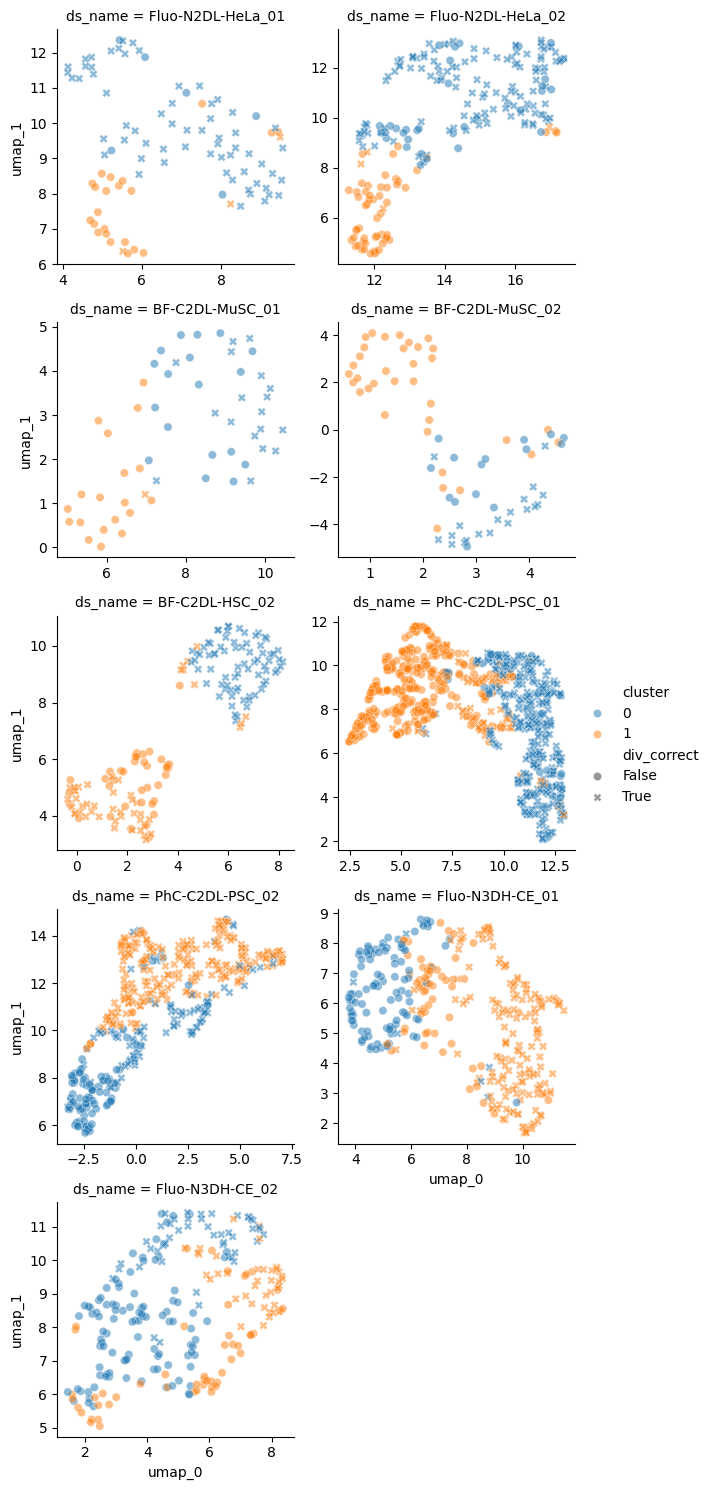

In [11]:
import seaborn as sns

grid = sns.FacetGrid(scaled_gmm_embed_df, col='ds_name', col_wrap=2, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='umap_0', y='umap_1', hue='cluster', style='div_correct', alpha=0.5)
grid.add_legend()

Looking at the confusion matrix...

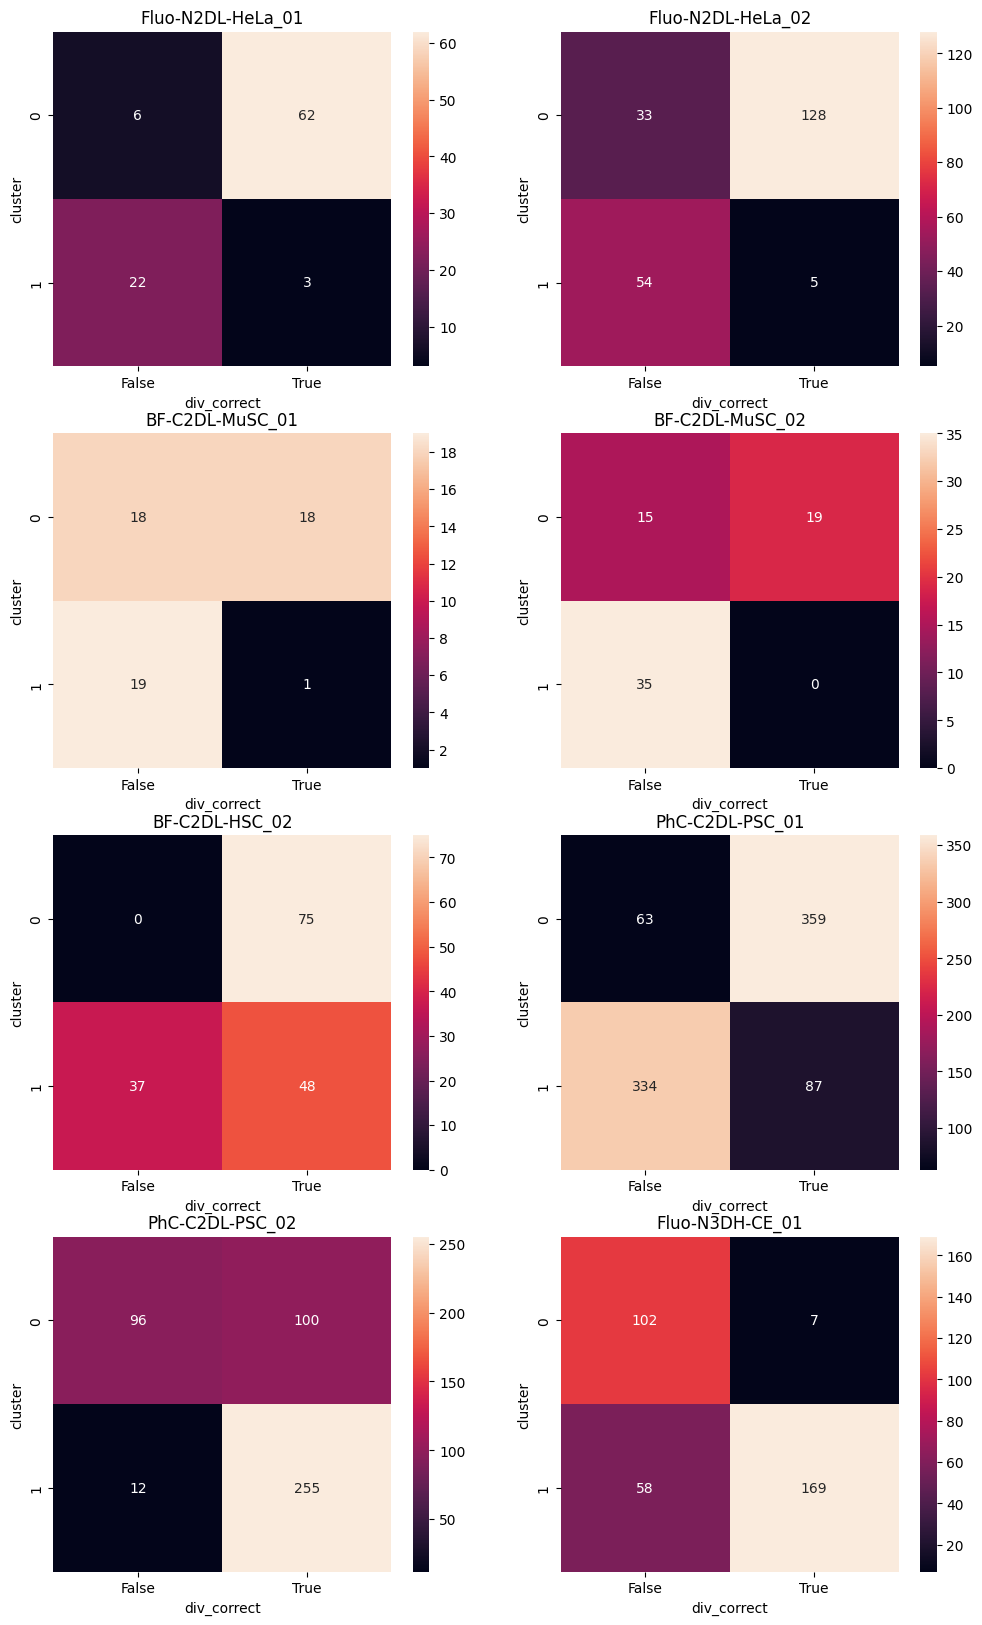

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,20), nrows=4, ncols=2)

targets = zip(scaled_gmm_embed_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = scaled_gmm_embed_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.div_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax)
    ax.set_title(key)
plt.show()

### Conclusion

Although the classifier, given labelled training data, is capable of achieving great accuracy in classifying divisions, the unsupervised clustering methods (k-means improved by GMM) don't seem capable of capturing the same signal in the absence of labels, regardless of whether the features are scaled, and whether we remove columns with less importance to the classifier. PCA/UMAP embeddings do seem to show some relationships, but it's not clear how we can capture that signal, if at all.

## Migrations

We now perform the same investigation for migrations. We note that proportionally, incorrect migration choices are much rarer than incorrect divisions. This is very likely to affect the classification results (supervised or otherwise)

### Data

To select all migrations from the dataset, we take only records with a valid first neighbour rank. We also compute a derived feature: the proportion of the given node's area covered by the area of the migration neighbour.

In [13]:
all_migrations = all_info_df[all_info_df.first_chosen_neighbour_rank >= 0]
all_migrations['mig_area_prop'] = all_migrations['first_child_area'] / all_migrations['node_area']
ds_names = all_migrations['ds_name'].unique()

columns_of_interest = [
    'first_chosen_neighbour_rank',
    'first_child_distance',
    'mig_area_prop',
    'mig_correct' # target
]

/tmp/ipykernel_9208/3096913425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_migrations['mig_area_prop'] = all_migrations['first_child_area'] / all_migrations['node_area']


### Supervised Classifier

Again we train a Random Forest classifier using a 20% test split and random CV search for the hyperparameters. We use the target column to stratify the train/test split.

In [14]:

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

record_ds_names = []
accuracies = []
n_mig = []
n_train_true = []
n_train_false = []
n_test_true = []
n_test_false = []
best_models = {}
searches = {}
for ds_name in ds_names:
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    # skip classifying if there's fewer than 30 incorrect edges
    if (n_wrong := len(data_df[data_df['mig_correct'] == False])) < 30:
        print(f'Skipping {ds_name} with {n_wrong} incorrect migrations.')
        continue
    X = data_df.drop(columns=['mig_correct'])
    y = data_df.mig_correct
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


    rf = RandomForestClassifier()
    param_dist = {
        'n_estimators': randint(50,500),
        'max_depth': randint(1,20)
    }
    search = RandomizedSearchCV(
        rf,
        param_distributions = param_dist,
        n_iter=5,
        cv=5
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_models[ds_name] = best_model
    searches[ds_name] = search
    
    record_ds_names.append(ds_name)
    accuracies.append(accuracy)
    n_mig.append(len(data_df))
    n_train_true.append(np.sum(y_train))
    n_train_false.append(len(y_train) - np.sum(y_train))
    n_test_true.append(np.sum(y_test))
    n_test_false.append(len(y_test) - np.sum(y_test))
classifier_df = pd.DataFrame({
    'ds_name': record_ds_names,
    'accuracy': accuracies,
    'n_mig': n_mig,
    'n_train_true': n_train_true,
    'n_train_false': n_train_false,
    'n_test_true': n_test_true,
    'n_test_false': n_test_false
})
print(classifier_df)

Skipping Fluo-C3DL-MDA231_01 with 4 incorrect migrations.
Skipping Fluo-C3DL-MDA231_02 with 15 incorrect migrations.
Skipping Fluo-N2DH-GOWT1_01 with 13 incorrect migrations.
Skipping PhC-C2DH-U373_01 with 0 incorrect migrations.
Skipping PhC-C2DH-U373_02 with 8 incorrect migrations.
Skipping Fluo-C2DL-MSC_01 with 0 incorrect migrations.
Skipping Fluo-C2DL-MSC_02 with 0 incorrect migrations.
Skipping Fluo-C3DH-H157_01 with 0 incorrect migrations.
Skipping Fluo-C3DH-H157_02 with 1 incorrect migrations.
Skipping DIC-C2DH-HeLa_01 with 11 incorrect migrations.
Skipping DIC-C2DH-HeLa_02 with 10 incorrect migrations.
Skipping Fluo-N3DH-CHO_01 with 0 incorrect migrations.
Skipping Fluo-N3DH-CHO_02 with 0 incorrect migrations.
Skipping BF-C2DL-HSC_01 with 22 incorrect migrations.
Skipping Fluo-C3DH-A549_01 with 0 incorrect migrations.
Skipping Fluo-C3DH-A549_02 with 0 incorrect migrations.
              ds_name  accuracy  n_mig  n_train_true  n_train_false  \
0  Fluo-N2DH-GOWT1_02  0.988914   

As we can see, again, the classifier performs very well. We check the CV output again, and predict against different train/test splits.

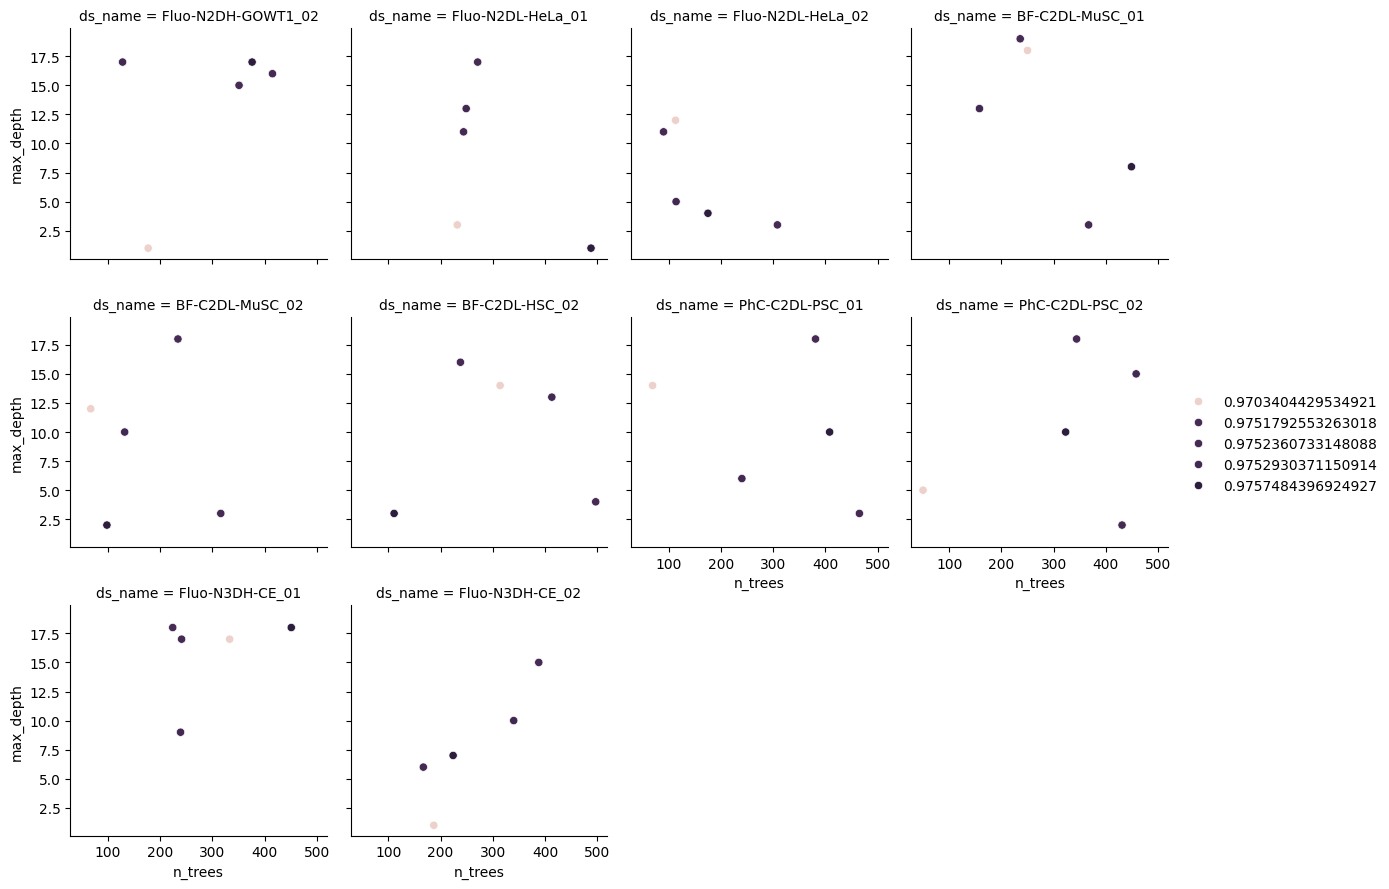

In [15]:
# check each search for whether we've "converged" on best values
import seaborn as sns

record_ds_names = []
n_estimators = []
max_depths = []
scores = []
for ds_name, search in searches.items():
    search_results = search.cv_results_
    m_depth = search_results['param_max_depth']
    n_est = search_results['param_n_estimators']
    score = search_results['mean_test_score']

    record_ds_names.extend([ds_name for _ in range(len(m_depth))])
    n_estimators.extend(n_est)
    max_depths.extend(m_depth)
    scores.extend(score)
search_df = pd.DataFrame({
    'ds_name': record_ds_names,
    'n_trees': n_estimators,
    'max_depth': max_depths,
    'score': scores
})

grid = sns.FacetGrid(search_df, col='ds_name', col_wrap=4, sharex=True, sharey=True, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='n_trees', y='max_depth', hue=score)
grid.add_legend()

In [16]:
from sklearn.model_selection import cross_val_score

record_ds_names = []
average_score = []
std_dev = []
for ds_name, model in best_models.items():
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    X = data_df.drop(columns=['mig_correct'])
    y = data_df.mig_correct
    scores = cross_val_score(model, X, y, cv=5)
    record_ds_names.append(ds_name)
    average_score.append(scores.mean())
    std_dev.append(scores.std())
cross_val_df = pd.DataFrame({
    'ds_name': record_ds_names,
    'average_score': average_score,
    'std_dev': std_dev
})
cross_val_df

,ds_name,average_score,std_dev
0,Fluo-N2DH-GOWT1_02,0.988909,0.001402
1,Fluo-N2DL-HeLa_01,0.981534,0.001959
2,Fluo-N2DL-HeLa_02,0.984771,0.000771
3,BF-C2DL-MuSC_01,0.964379,0.000363
4,BF-C2DL-MuSC_02,0.969975,0.001352
5,BF-C2DL-HSC_02,0.996581,0.000220
6,PhC-C2DL-PSC_01,0.979869,0.000957
7,PhC-C2DL-PSC_02,0.988741,0.001431
8,Fluo-N3DH-CE_01,0.981941,0.002555
9,Fluo-N3DH-CE_02,0.975544,0.000712


We look at the feature importance (caveat that it's not always good with features that take on lots of different values) and neighbour rank doesn't really seem to matter.

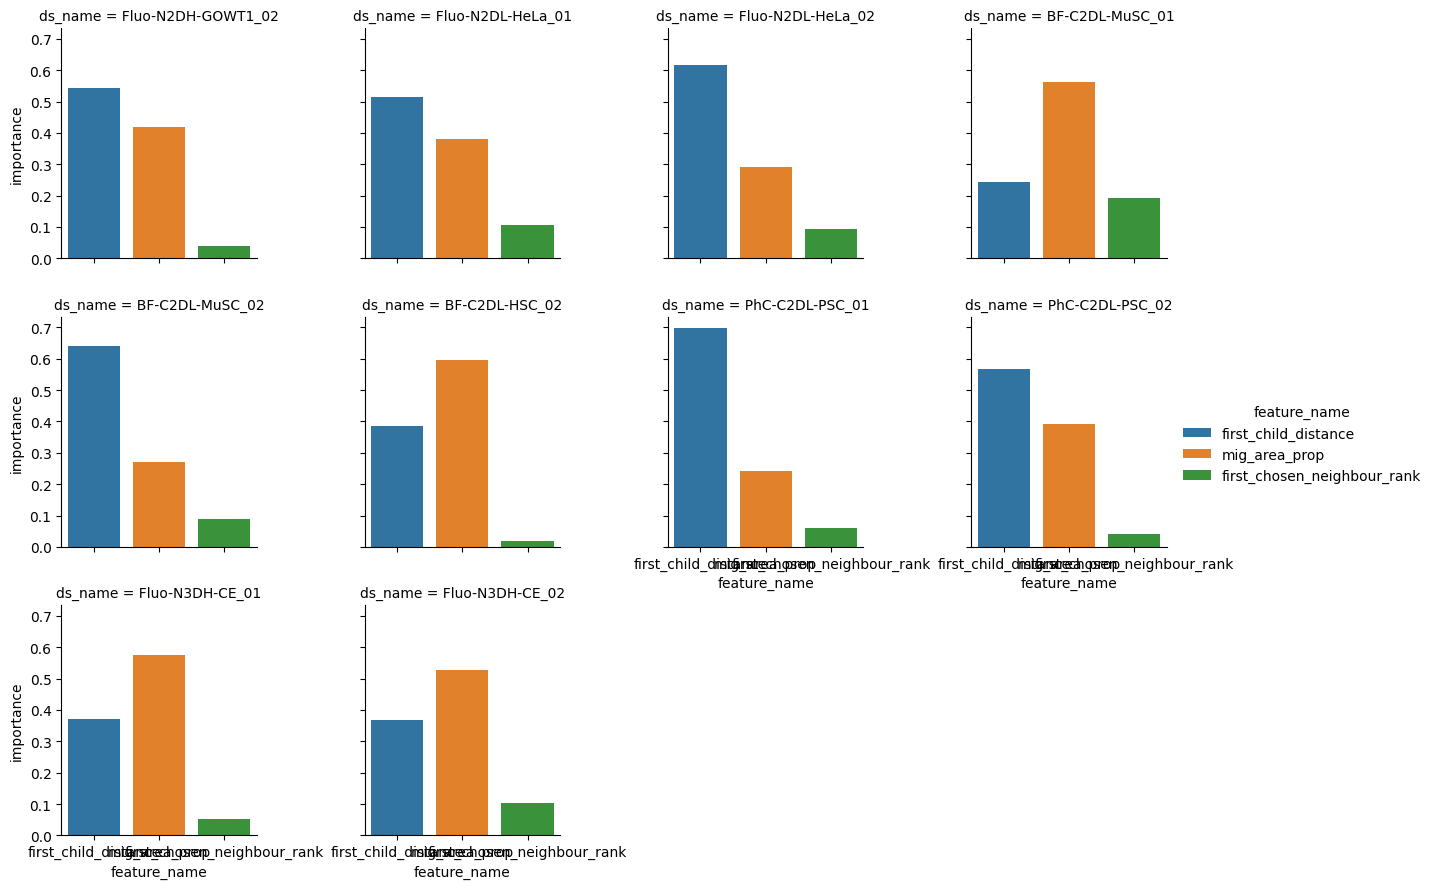

In [17]:
import seaborn as sns

record_ds_names = []
feature_names = []
importances = []
for ds_name, model in best_models.items():
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    for feature_name, importance in feature_importances.items():
        record_ds_names.append(ds_name)
        feature_names.append(feature_name)
        importances.append(importance)
importance_df = pd.DataFrame({
    'ds_name': record_ds_names,
    'feature_name': feature_names,
    'importance': importances
})

grid = sns.FacetGrid(importance_df, col='ds_name', col_wrap=4, sharex=True, legend_out=True, hue='feature_name')
grid.map_dataframe(sns.barplot, x='feature_name', y='importance')
grid.add_legend()

### K-Means Clustering

We look at whether K-Means can produce similar classification accuracy unsupervised.

In [18]:
from sklearn.cluster import k_means

k_mean_cols = columns_of_interest
kmeans_clustered = {}
for ds_name in ds_names:
    data_df = all_migrations[all_migrations.ds_name == ds_name][columns_of_interest]
    X = data_df.drop(columns=['mig_correct'])

    centroid, label, inertia = k_means(
        X, n_clusters=2, n_init="auto", random_state=0
    )
    data_df['cluster'] = label

    kmeans_clustered[ds_name] = data_df

Again, we would hope that one of the diagonals of the confusion matrix is very bright and the other is dim, signifying that one of our clusters is correctly capturing the True migrations, and the other the False. 

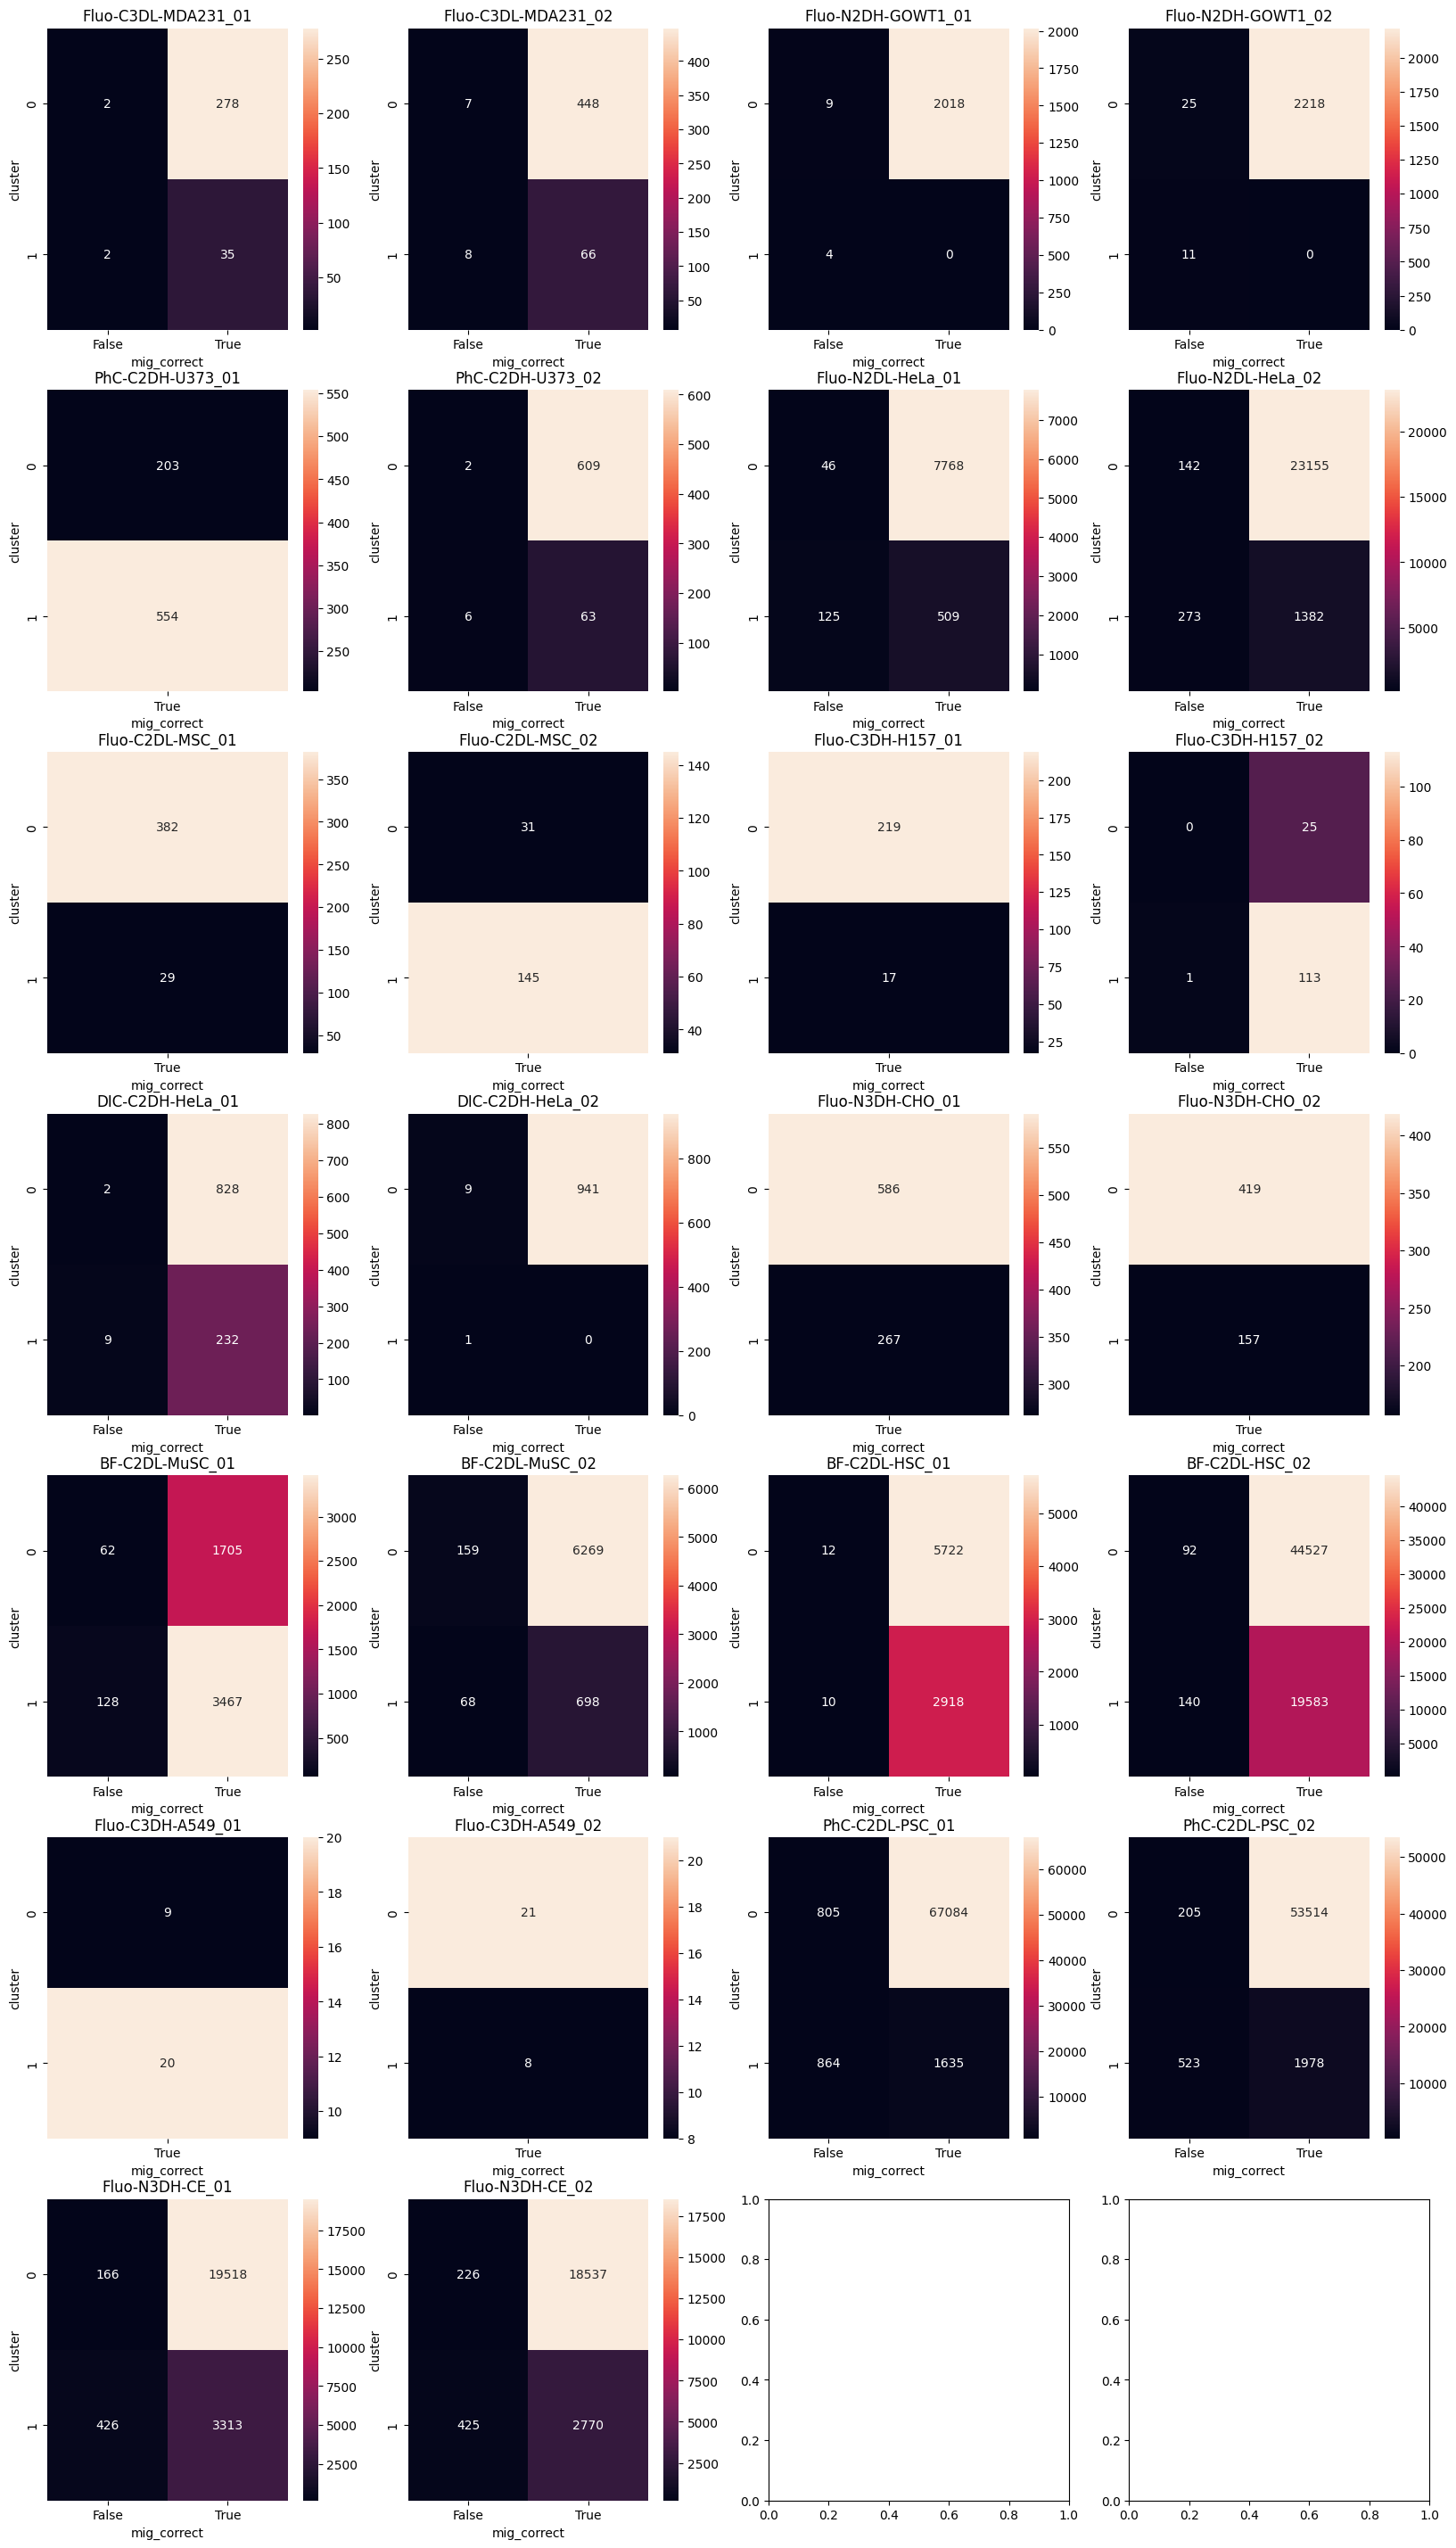

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20,36), nrows=7, ncols=4)

targets = zip(kmeans_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = kmeans_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.mig_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax)
    ax.set_title(key)
plt.show()

Unfortunately, this is not really the case. While it's true that  we find one very large cluster of correct migrations, there is nevertheless considerable confusion in the remaining classes. There is one issue of k-means always finding two clusters, even when there are actually no incorrect labels. There are also multiple instances of the True migrations being almost evenly divided between one cluster and the other.

### GMM, Viz

We scale the features (removing the neighbour rank), and use a GMM to see whether we get any improvement. Note again that since we are requesting two target clusters, the datasets that are fully correct will never be classified "correctly" still. Since we only have two features, we can plot them directly.

In [20]:
# try gmm on scaled data

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap

scaled_gmm_embed_cols = [
    'first_child_distance',
    'mig_area_prop',
    'mig_correct' # target
]
scaled_gmm_embed_clustered = {}
for ds_name in ds_names:
    data_df = all_migrations[all_migrations.ds_name == ds_name][scaled_gmm_embed_cols]
    X = data_df.drop(columns=['mig_correct'])
    X = StandardScaler().fit_transform(X)

    label = GaussianMixture(n_components=2, init_params='kmeans').fit_predict(X)
    proba = GaussianMixture(n_components=2, init_params='kmeans').fit(X).predict_proba(X)

    data_df['cluster'] = label
    data_df[['proba_0', 'proba_1']] = proba
    data_df[['scaled_distance', 'scaled_prop']] = X
    data_df['ds_name'] = ds_name

    scaled_gmm_embed_clustered[ds_name] = data_df
scaled_gmm_embed_df = pd.concat(scaled_gmm_embed_clustered.values())

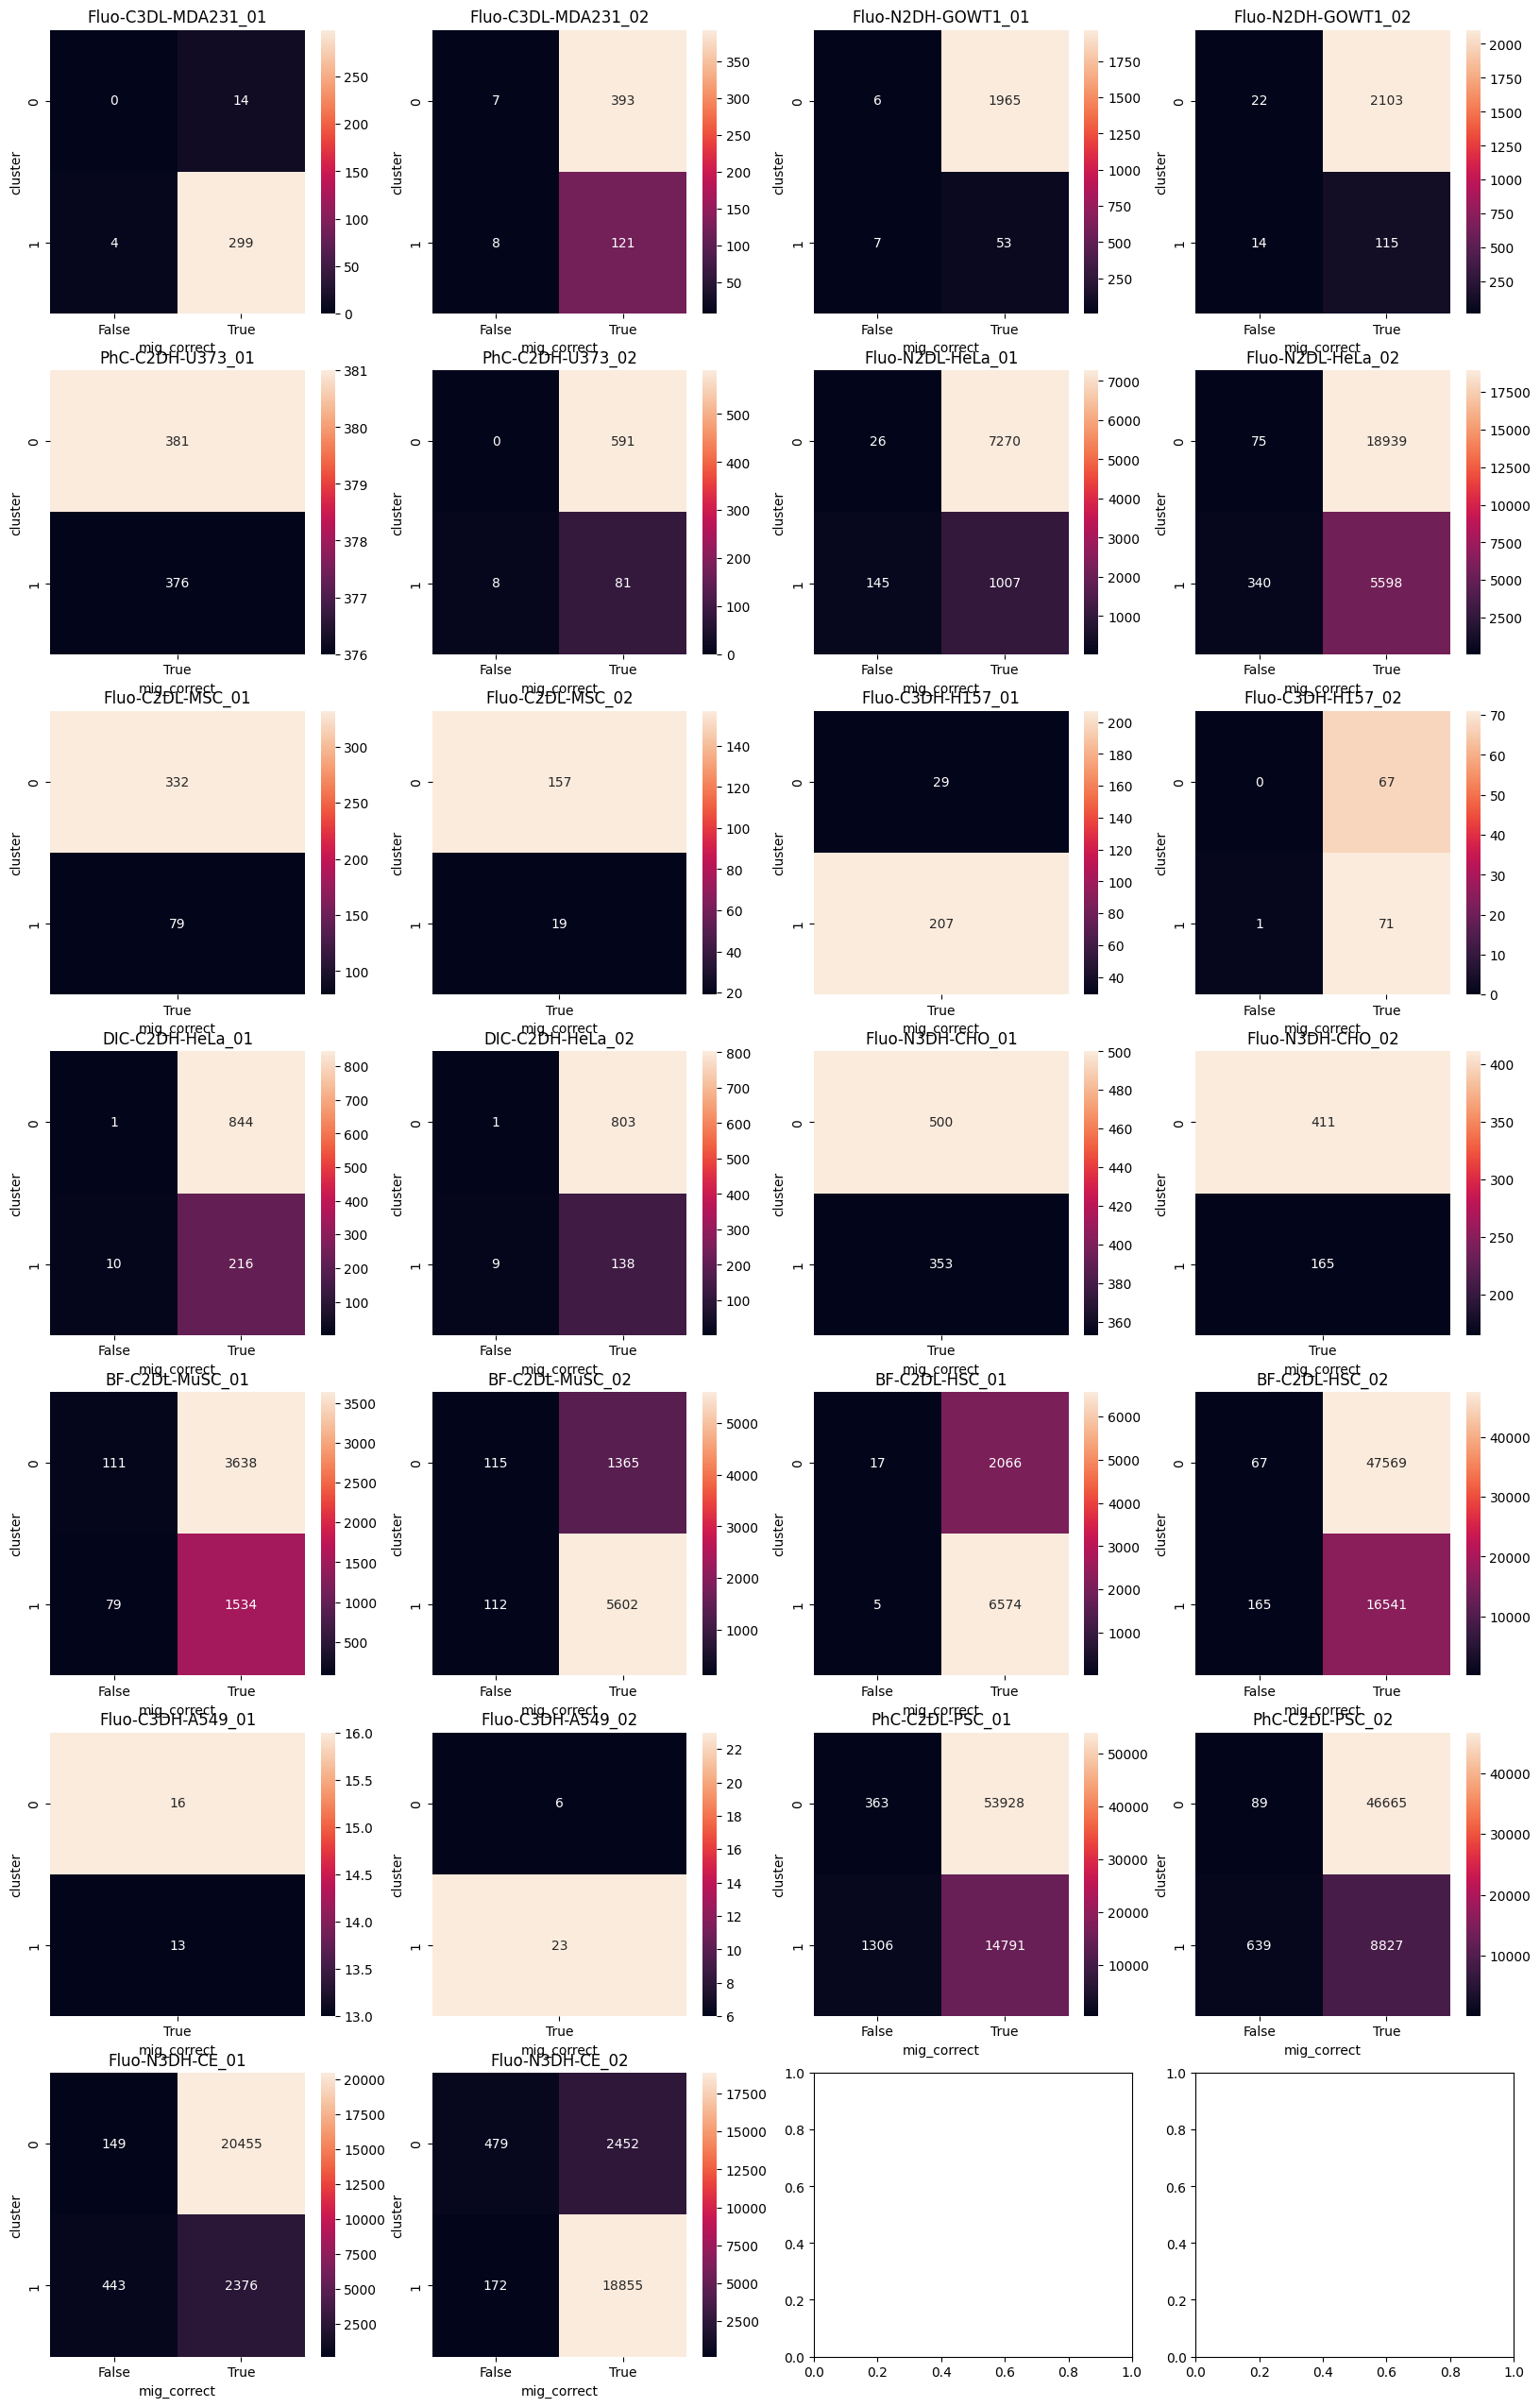

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20,36), nrows=7, ncols=4)

targets = zip(scaled_gmm_embed_clustered.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    info = scaled_gmm_embed_clustered[key]
    cont_table = pd.crosstab(info.cluster, info.mig_correct)
    sns.heatmap(cont_table, annot=True, fmt='g', ax=ax)
    ax.set_title(key) 
plt.show()

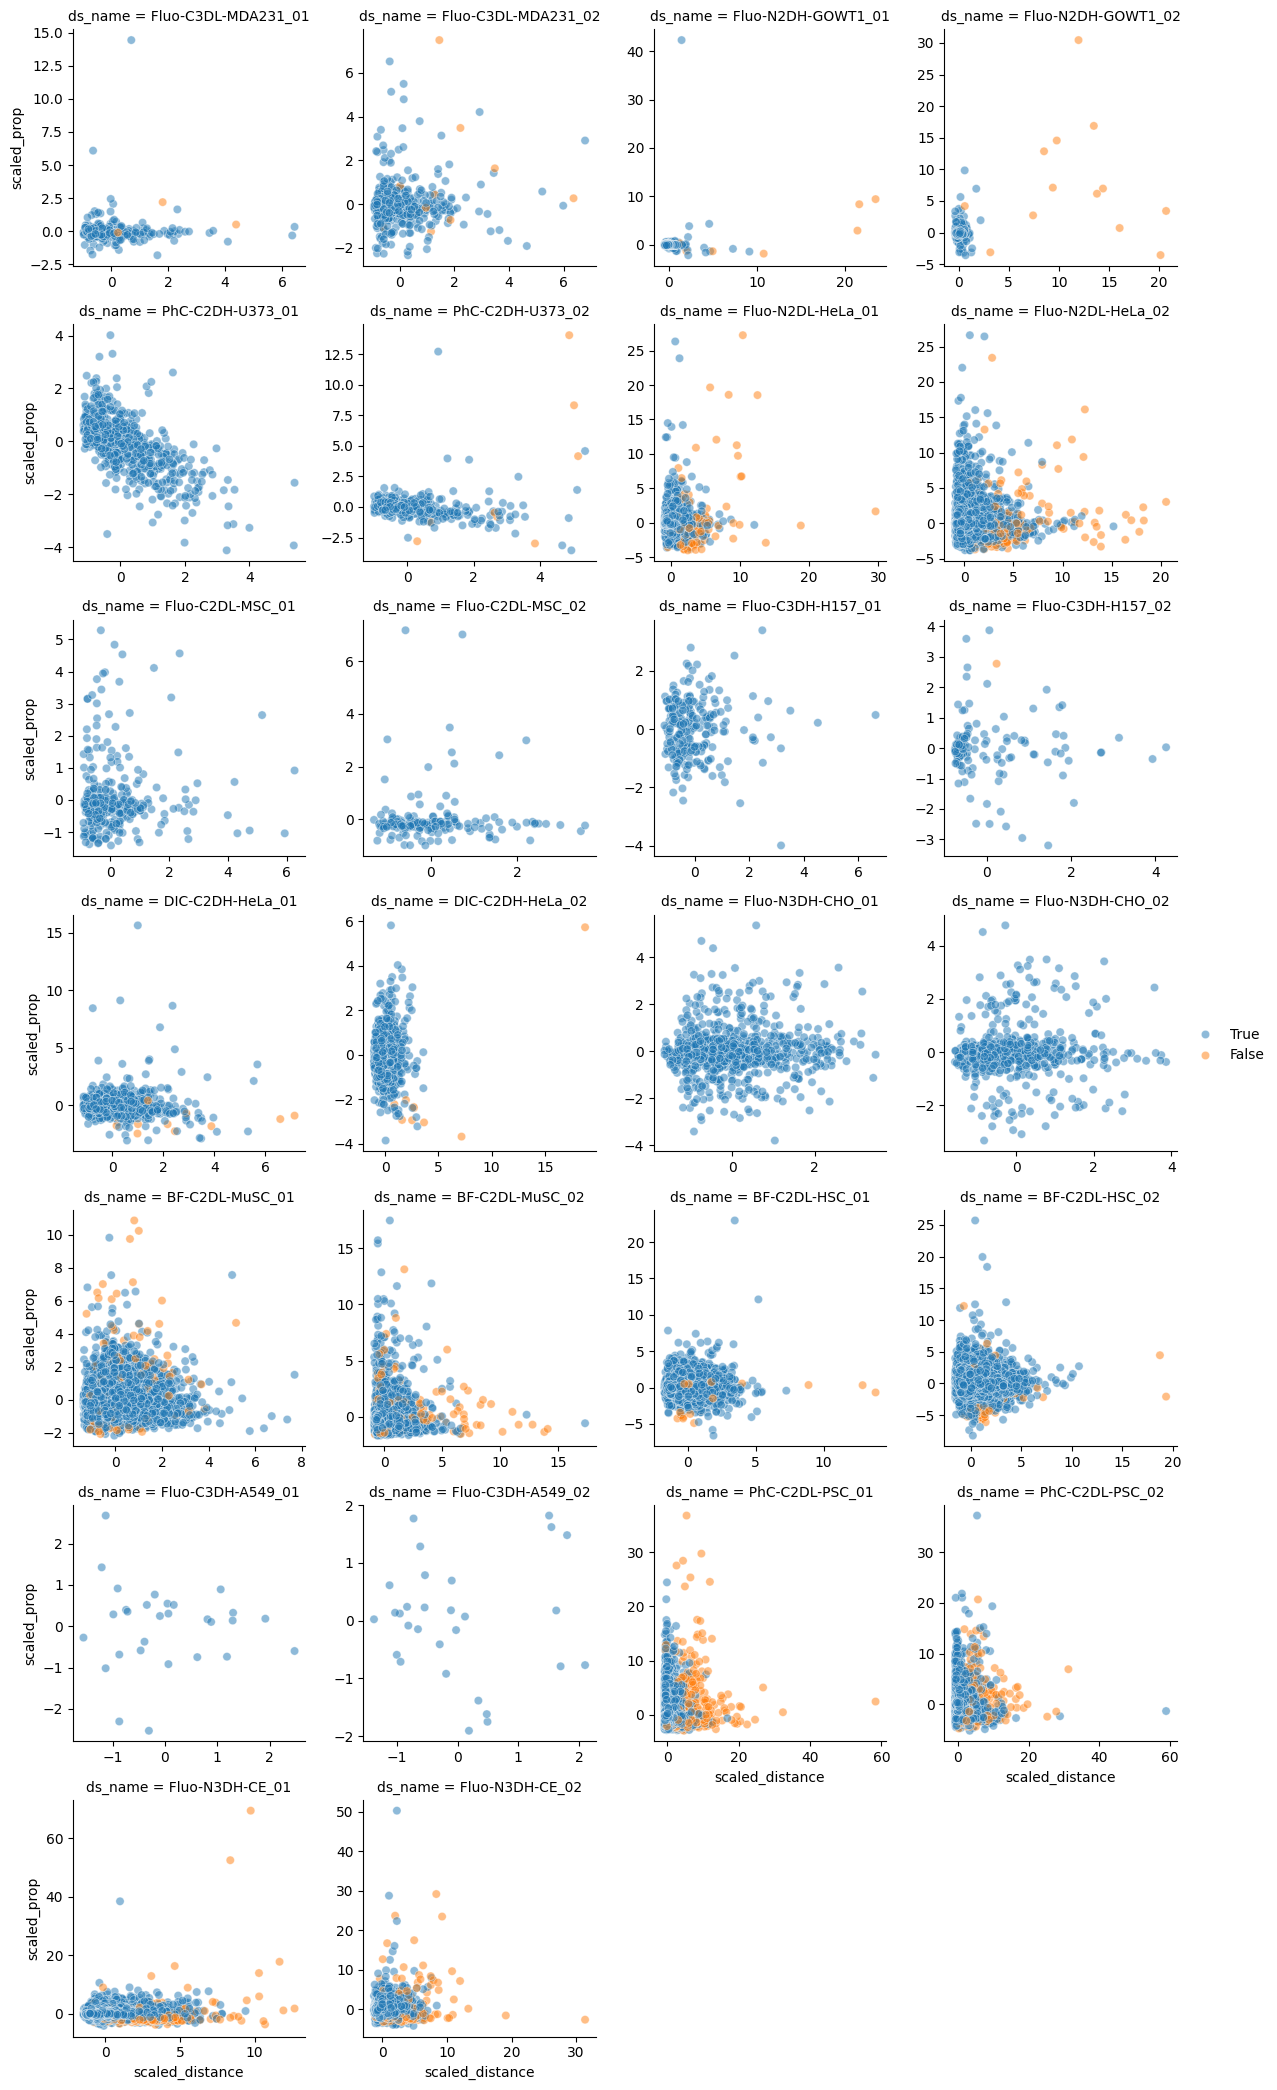

In [22]:
import seaborn as sns
scaled_gmm_embed_df.sort_values(by='mig_correct', ascending=False)
grid = sns.FacetGrid(scaled_gmm_embed_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.scatterplot, x='scaled_distance', y='scaled_prop', alpha=0.5, hue='mig_correct', hue_order=[True, False])
grid.add_legend()

### Conclusion

Similarly to divisions, but exacerbated by the difference in sample sizes, the unsupervised clustering is not really capable of capturing the signal used by the supervised classifier to achieve its accuracy.